#Imports






In [143]:
!pip install pmdarima

In [144]:
!pip install pandas-profiling

In [145]:
!pip install dtale

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.pipeline import Pipeline
from pandas_profiling import ProfileReport


import warnings
warnings.filterwarnings('ignore')



#Business Goal

To build a model that can predict sales of Adidas product provided the range of dates

#Loading data

In [147]:
df = pd.read_excel('/content/Men Apparel.xlsx')

In [148]:
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Apparel,50,1200,600000,300000.0,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Apparel,50,1000,500000,150000.0,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Men's Apparel,40,1000,400000,140000.0,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Men's Apparel,45,850,382500,133875.0,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60,900,540000,162000.0,0.30,In-store


#Data Preprocessing

Removing delimiters

In [149]:
# df = df.replace(',', '', regex = True)
# df['Price per Unit'] = str(df['Price per Unit'])
# df['Operating Profit'] = str(df['Operating Profit'])
# df['Units Sold'] = str(df['Units Sold'])
# df['Total Sales'] = str(df['Total Sales'])
# df['Price per Unit'] = df['Price per Unit'].str.replace('$', '')
# df['Operating Profit'] = df['Operating Profit'].str.replace('$', '')
# df['Units Sold'] = df['Units Sold'].str.replace('$', '')
# df['Total Sales'] = df['Total Sales'].str.replace('$', '')



Missing Values

In [150]:
df.isnull().sum()

Retailer            0
Retailer ID         0
Invoice Date        0
Region              0
State               0
City                0
Product             0
Price per Unit      0
Units Sold          0
Total Sales         0
Operating Profit    0
Operating Margin    0
Sales Method        0
dtype: int64

Handling categorical variables

In [277]:
df.shape

(1606, 13)

In [151]:
columns_to_encode = ['Retailer','Region', 'State', 'City', 'Product', 'Sales Method']
encoded_df = pd.get_dummies(df, columns=columns_to_encode)
print(list(encoded_df))

['Retailer ID', 'Invoice Date', 'Price per Unit', 'Units Sold', 'Total Sales', 'Operating Profit', 'Operating Margin', 'Retailer_Amazon', 'Retailer_Foot Locker', "Retailer_Kohl's", 'Retailer_Sports Direct', 'Retailer_Walmart', 'Retailer_West Gear', 'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West', 'State_Alabama', 'State_Alaska', 'State_California', 'State_Colorado', 'State_Florida', 'State_Hawaii', 'State_Illinois', 'State_Maine', 'State_Minnesota', 'State_Montana', 'State_Nebraska', 'State_Nevada', 'State_New York', 'State_Pennsylvania', 'State_Tennessee', 'State_Texas', 'State_Virginia', 'State_Washington', 'State_Wyoming', 'City_Albany', 'City_Anchorage', 'City_Billings', 'City_Birmingham', 'City_Cheyenne', 'City_Chicago', 'City_Dallas', 'City_Denver', 'City_Honolulu', 'City_Houston', 'City_Knoxville', 'City_Las Vegas', 'City_Los Angeles', 'City_Miami', 'City_Minneapolis', 'City_New York', 'City_Omaha', 'City_Orlando', 'City_Philadelphia', 'Ci

In [152]:
print(list(encoded_df))

['Retailer ID', 'Invoice Date', 'Price per Unit', 'Units Sold', 'Total Sales', 'Operating Profit', 'Operating Margin', 'Retailer_Amazon', 'Retailer_Foot Locker', "Retailer_Kohl's", 'Retailer_Sports Direct', 'Retailer_Walmart', 'Retailer_West Gear', 'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West', 'State_Alabama', 'State_Alaska', 'State_California', 'State_Colorado', 'State_Florida', 'State_Hawaii', 'State_Illinois', 'State_Maine', 'State_Minnesota', 'State_Montana', 'State_Nebraska', 'State_Nevada', 'State_New York', 'State_Pennsylvania', 'State_Tennessee', 'State_Texas', 'State_Virginia', 'State_Washington', 'State_Wyoming', 'City_Albany', 'City_Anchorage', 'City_Billings', 'City_Birmingham', 'City_Cheyenne', 'City_Chicago', 'City_Dallas', 'City_Denver', 'City_Honolulu', 'City_Houston', 'City_Knoxville', 'City_Las Vegas', 'City_Los Angeles', 'City_Miami', 'City_Minneapolis', 'City_New York', 'City_Omaha', 'City_Orlando', 'City_Philadelphia', 'Ci

Converting dataframe to time stamped dataframe

In [153]:
encoded_df.set_index('Invoice Date', inplace = True)

In [154]:
encoded_df.index = pd.to_datetime(encoded_df.index)

In [155]:
encoded_df.sort_index(inplace = True)

In [156]:
encoded_df

,Retailer ID,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Retailer_Amazon,Retailer_Foot Locker,Retailer_Kohl's,Retailer_Sports Direct,...,City_Omaha,City_Orlando,City_Philadelphia,City_Portland,City_Richmond,City_San Francisco,City_Seattle,Product_Men's Apparel,Sales Method_In-store,Sales Method_Outlet
Invoice Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1185732,50,1200,600000,300000.0,0.50,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2020-01-01,1185732,75,275,206250,61875.0,0.30,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2020-01-02,1185732,50,1000,500000,150000.0,0.30,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2020-01-02,1128299,35,450,157500,63000.0,0.40,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
2020-01-03,1128299,45,450,202500,50625.0,0.25,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,1185732,45,150,67500,27000.0,0.40,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2021-12-30,1185732,60,175,105000,42000.0,0.40,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2021-12-30,1185732,45,125,56250,16875.0,0.30,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1


# Feature Selection & Exploratory Data Analysis

In [ ]:
df.info()

In [ ]:
encoded_df.info()

In [ ]:
df.describe()

In [ ]:
encoded_df.dtypes

Correlation Matrix

In [167]:
corr=df.corr()
corr

,Retailer ID,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin
Retailer ID,1.000000,-0.526491,0.070482,-0.193698,0.024472,0.367422
Price per Unit,-0.526491,1.000000,0.131902,0.568462,0.380892,-0.223375
Units Sold,0.070482,0.131902,1.000000,0.868230,0.798889,0.085358
Total Sales,-0.193698,0.568462,0.868230,1.000000,0.847961,-0.034152
Operating Profit,0.024472,0.380892,0.798889,0.847961,1.000000,0.441964
Operating Margin,0.367422,-0.223375,0.085358,-0.034152,0.441964,1.000000


In [168]:
df['Units Sold'] = df['Units Sold'].astype(int)
df['Total Sales'] = df['Total Sales'].astype(int)
df['Operating Profit'] = df['Operating Profit'].astype(int)

<Axes: >

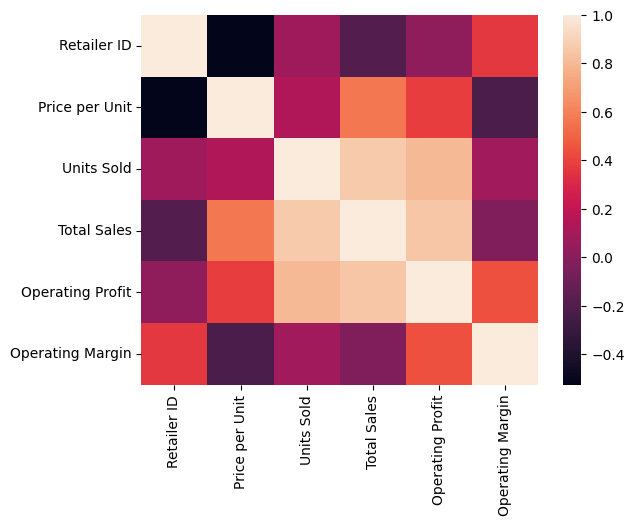

In [169]:
sns.heatmap(df.corr())

Granger causality test

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
maxlag = 1
test   = 'ssr_chi2test'

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
new = encoded_df[['Total Sales','Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West', 'Sales Method_In-store', 'Sales Method_Outlet']].copy()

In [ ]:
grangers_causation_matrix(new, variables = new.columns)

,Total Sales_x,Region_Midwest_x,Region_Northeast_x,Region_South_x,Region_Southeast_x,Region_West_x,Sales Method_In-store_x,Sales Method_Outlet_x
Total Sales_y,1.0000,0.1251,0.3478,0.2672,0.2133,0.0481,0.2345,0.2345
Region_Midwest_y,0.2588,1.0000,0.4183,0.3418,0.1909,0.6031,0.4293,0.4293
Region_Northeast_y,0.1545,0.8161,1.0000,0.6462,0.9776,0.8857,0.1970,0.1970
Region_South_y,0.6142,0.4824,0.4242,1.0000,0.0763,0.9644,0.4262,0.4262
Region_Southeast_y,0.0023,0.2049,0.7503,0.4152,1.0000,0.4345,0.4563,0.4563
Region_West_y,0.2692,0.9142,0.1656,0.4650,0.3429,1.0000,0.3899,0.3899
Sales Method_In-store_y,0.0143,0.4016,0.8917,0.5090,0.3893,0.4572,1.0000,1.0000
Sales Method_Outlet_y,0.0143,0.4016,0.8917,0.5090,0.3893,0.4572,1.0000,1.0000


#Automated EDA

In [170]:
encoded_df

,Retailer ID,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Retailer_Amazon,Retailer_Foot Locker,Retailer_Kohl's,Retailer_Sports Direct,...,City_Omaha,City_Orlando,City_Philadelphia,City_Portland,City_Richmond,City_San Francisco,City_Seattle,Product_Men's Apparel,Sales Method_In-store,Sales Method_Outlet
Invoice Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1185732,50,1200,600000,300000.0,0.50,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2020-01-01,1185732,75,275,206250,61875.0,0.30,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2020-01-02,1185732,50,1000,500000,150000.0,0.30,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2020-01-02,1128299,35,450,157500,63000.0,0.40,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
2020-01-03,1128299,45,450,202500,50625.0,0.25,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,1185732,45,150,67500,27000.0,0.40,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2021-12-30,1185732,60,175,105000,42000.0,0.40,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2021-12-30,1185732,45,125,56250,16875.0,0.30,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1


In [171]:
report = ProfileReport(df, title = "Pandas Profiling Report", explorative = True)
report.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [172]:
import dtale
import dtale.app as dtale_app
dtale.app.USE_COLAB = True

In [173]:
dtale.show(df)

https://5pqlga0t7ep-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/2

Resampling Data

In [174]:
encoded_df = encoded_df.resample(rule = 'W').mean()

In [175]:
encoded_df

,Retailer ID,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Retailer_Amazon,Retailer_Foot Locker,Retailer_Kohl's,Retailer_Sports Direct,...,City_Omaha,City_Orlando,City_Philadelphia,City_Portland,City_Richmond,City_San Francisco,City_Seattle,Product_Men's Apparel,Sales Method_In-store,Sales Method_Outlet
Invoice Date,,,,,,,,,,,,,,,,,,,,,
2020-01-05,1.162759e+06,49.000000,687.500000,332625.000000,118962.500000,0.350000,0.000000,0.600000,0.00,0.00,...,0.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,1.0,0.500000,0.500000
2020-01-12,1.145529e+06,46.500000,572.500000,270375.000000,98012.500000,0.375000,0.000000,0.300000,0.00,0.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.200000,0.800000
2020-01-19,1.128299e+06,52.857143,371.428571,191964.285714,62107.142857,0.335714,0.000000,0.000000,0.00,0.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,1.000000
2020-01-26,1.154807e+06,57.692308,655.384615,353942.307692,125043.269231,0.357692,0.000000,0.461538,0.00,0.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,1.000000
2020-02-02,1.157016e+06,56.785714,682.142857,364464.285714,130214.285714,0.367857,0.000000,0.500000,0.00,0.00,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05,1.185732e+06,60.714286,289.285714,179642.857143,73205.357143,0.392857,0.000000,1.000000,0.00,0.00,...,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,1.000000
2021-12-12,1.171948e+06,62.800000,510.000000,325950.000000,107670.000000,0.332000,0.000000,0.440000,0.24,0.16,...,0.0,0.000000,0.280000,0.000000,0.0,0.0,0.0,1.0,0.480000,0.520000
2021-12-19,1.167595e+06,66.052632,365.789474,267500.000000,85825.657895,0.326316,0.315789,0.368421,0.00,0.00,...,0.0,0.315789,0.368421,0.315789,0.0,0.0,0.0,1.0,0.315789,0.684211


#Seasonal Decomposition

In [176]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

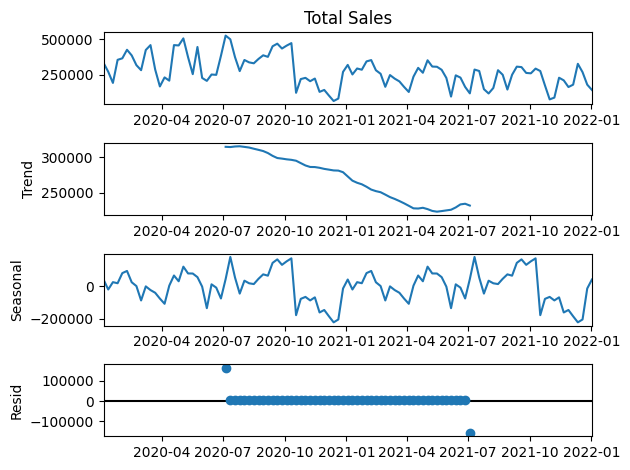

In [177]:
result = seasonal_decompose(encoded_df['Total Sales'], model = 'additive')
result.plot();

In [178]:
result.seasonal

Invoice Date
2020-01-05     41285.626612
2020-01-12    -19725.795235
2020-01-19     25096.173487
2020-01-26     18568.506362
2020-02-02     80380.411124
                  ...      
2021-12-05   -183613.829661
2021-12-12   -220534.459812
2021-12-19   -203078.750678
2021-12-26    -13684.268077
2022-01-02     41285.626612
Freq: W-SUN, Name: seasonal, Length: 105, dtype: float64

In [179]:
!pip install pymannkendall

In [180]:
import pymannkendall as mk

In [181]:
mk.original_test(encoded_df['Units Sold'])

Mann_Kendall_Test(trend='decreasing', h=True, p=2.5362858422139922e-05, z=-4.211546273940495, Tau=-0.27875457875457876, s=-1522.0, var_s=130429.33333333333, slope=-2.4394154232863894, intercept=630.4210305823208)

#SMA

In [182]:
encoded_df['2-week-SMA'] = encoded_df['Total Sales'].rolling(window = 2).mean()
encoded_df['3-week-SMA'] = encoded_df['Total Sales'].rolling(window = 3).mean()

In [183]:
encoded_df['2-week-SMA']

Invoice Date
2020-01-05              NaN
2020-01-12    301500.000000
2020-01-19    231169.642857
2020-01-26    272953.296703
2020-02-02    359203.296703
                  ...      
2021-12-05    171339.285714
2021-12-12    252796.428571
2021-12-19    296725.000000
2021-12-26    223578.125000
2022-01-02    161078.125000
Freq: W-SUN, Name: 2-week-SMA, Length: 105, dtype: float64

In [184]:
encoded_df['3-week-SMA']

Invoice Date
2020-01-05              NaN
2020-01-12              NaN
2020-01-19    264988.095238
2020-01-26    272093.864469
2020-02-02    303456.959707
                  ...      
2021-12-05    184158.482143
2021-12-12    222876.190476
2021-12-19    257697.619048
2021-12-26    257702.083333
2022-01-02    196552.083333
Freq: W-SUN, Name: 3-week-SMA, Length: 105, dtype: float64

<Axes: xlabel='Invoice Date'>

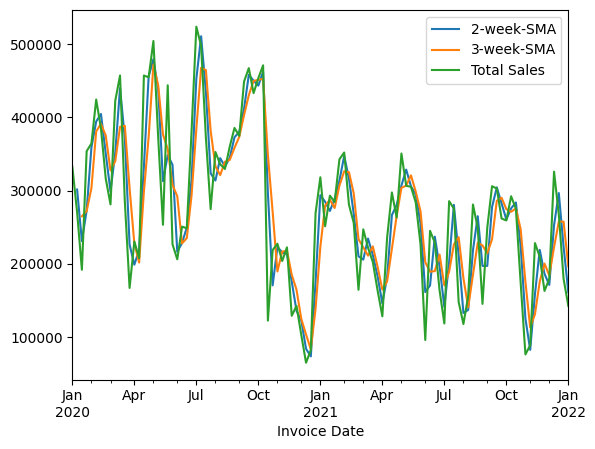

In [185]:

encoded_df['2-week-SMA'].plot(legend = True)
encoded_df['3-week-SMA'].plot(legend = True)
encoded_df['Total Sales'].plot(legend = True)

In [186]:
encoded_df['6-week-SMA'] = encoded_df['Total Sales'].rolling(window = 6).mean()
encoded_df['12-week-SMA'] = encoded_df['Total Sales'].rolling(window = 12).mean()

<Axes: xlabel='Invoice Date'>

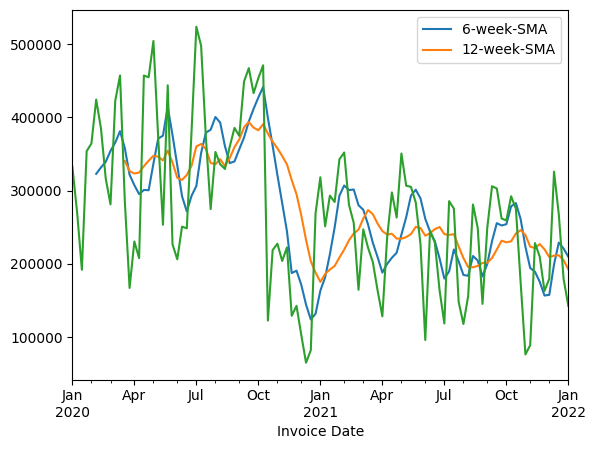

In [187]:
encoded_df['6-week-SMA'].plot(legend = True)
encoded_df['12-week-SMA'].plot(legend = True)
encoded_df['Total Sales'].plot()

#EWMA

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.


The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

Used both adjust = True and adjust = False and various values of span

In [188]:
encoded_df['EWMA'] = encoded_df['Total Sales'].ewm(adjust = False, span = 1).mean()

In [189]:
encoded_df['EWMA']

Invoice Date
2020-01-05    332625.000000
2020-01-12    270375.000000
2020-01-19    191964.285714
2020-01-26    353942.307692
2020-02-02    364464.285714
                  ...      
2021-12-05    179642.857143
2021-12-12    325950.000000
2021-12-19    267500.000000
2021-12-26    179656.250000
2022-01-02    142500.000000
Freq: W-SUN, Name: EWMA, Length: 105, dtype: float64

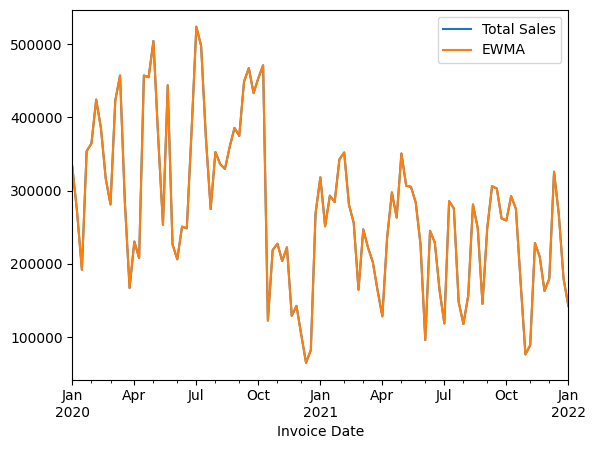

In [190]:
encoded_df['Total Sales'].plot(legend = True)
encoded_df['EWMA'].plot(legend =True);


In [191]:
train_data = encoded_df[:80]
test_data = encoded_df[80:]

#Evaluation Metrics

SMA

In [192]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [193]:
mean_absolute_error(encoded_df['Total Sales'][2:],encoded_df['3-week-SMA'][2:])

50052.06011292774

In [194]:
mean_squared_error(encoded_df['Total Sales'][2:],encoded_df['3-week-SMA'][2:])

4139571236.247698

In [195]:
np.sqrt(mean_squared_error(encoded_df['Total Sales'][2:],encoded_df['3-week-SMA'][2:]))

64339.49981347149

In [196]:
mean_absolute_error(encoded_df['Total Sales'][1:],encoded_df['2-week-SMA'][1:])

33355.06246373608

In [197]:
mean_squared_error(encoded_df['Total Sales'][1:],encoded_df['2-week-SMA'][1:])

2013770999.9527435

In [198]:
np.sqrt(mean_squared_error(encoded_df['Total Sales'][1:],encoded_df['2-week-SMA'][1:]))

44875.05988801289

EWMA Evaluation

In [199]:
encoded_df['EWMA']

Invoice Date
2020-01-05    332625.000000
2020-01-12    270375.000000
2020-01-19    191964.285714
2020-01-26    353942.307692
2020-02-02    364464.285714
                  ...      
2021-12-05    179642.857143
2021-12-12    325950.000000
2021-12-19    267500.000000
2021-12-26    179656.250000
2022-01-02    142500.000000
Freq: W-SUN, Name: EWMA, Length: 105, dtype: float64

In [200]:
mean_absolute_error(test_data['Total Sales'][:6],encoded_df['EWMA']['2021-10-17': '2021-11-21'])

37896.05654761905

In [201]:
mean_squared_error(test_data['Total Sales'][:6],encoded_df['EWMA']['2021-10-17': '2021-11-21'])

1881418420.9572442

In [202]:
np.sqrt(mean_squared_error(test_data['Total Sales'][:6],encoded_df['EWMA']['2021-10-17': '2021-11-21']))

43375.32041330927

In [203]:
encoded_df['Total Sales'].mean()

272724.4011368567

#Holt Winters Method

In [204]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [205]:
span = 2
alpha = 2 / (span + 1)

In [206]:
encoded_df['EWMA'] = encoded_df['Total Sales'].ewm(alpha = alpha, adjust = False).mean()

In [207]:
encoded_df['EWMA']

Invoice Date
2020-01-05    332625.000000
2020-01-12    291125.000000
2020-01-19    225017.857143
2020-01-26    310967.490842
2020-02-02    346632.020757
                  ...      
2021-12-05    178400.073024
2021-12-12    276766.691008
2021-12-19    270588.897003
2021-12-26    209967.132334
2022-01-02    164989.044111
Freq: W-SUN, Name: EWMA, Length: 105, dtype: float64

In [208]:
model = SimpleExpSmoothing(encoded_df['Total Sales'])

In [209]:
fitted_model = model.fit(smoothing_level = alpha, optimized = False)

In [210]:
encoded_df['SES7'] = fitted_model.fittedvalues.shift(-1)

Double Exponential Smoothing

In [211]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [212]:
encoded_df['DES7'] = ExponentialSmoothing(encoded_df['Total Sales'], trend = 'add').fit().fittedvalues.shift(-1)

<Axes: xlabel='Invoice Date'>

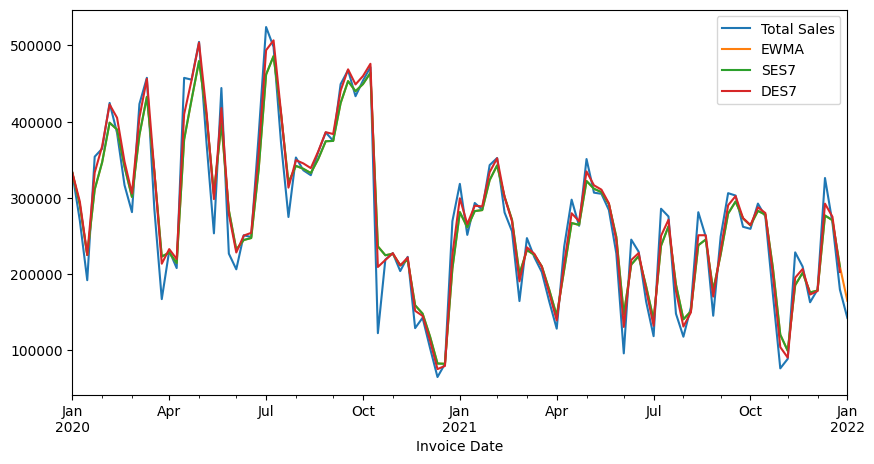

In [213]:
encoded_df[['Total Sales','EWMA', 'SES7', 'DES7']].plot(figsize = (10,5))


In [214]:
train_size = len(train_data)
test_size = len(test_data)

In [215]:
test_predictions = fitted_model.forecast(6)

In [216]:
test_predictions

2022-01-09    164989.044111
2022-01-16    164989.044111
2022-01-23    164989.044111
2022-01-30    164989.044111
2022-02-06    164989.044111
2022-02-13    164989.044111
Freq: W-SUN, dtype: float64

Triple Exponential Smoothing

In [217]:
encoded_df['TES7'] = ExponentialSmoothing(encoded_df['Total Sales'], trend = 'add', seasonal = 'add').fit().fittedvalues.shift(-1)

<Axes: xlabel='Invoice Date'>

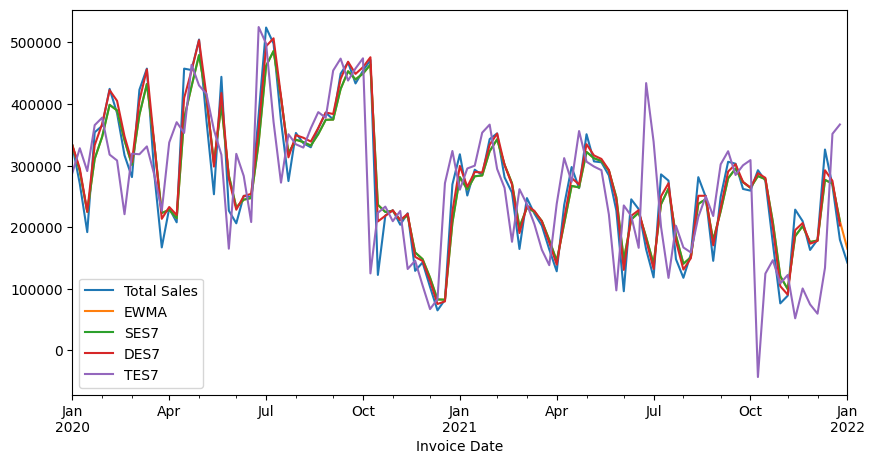

In [218]:
encoded_df[['Total Sales','EWMA', 'SES7', 'DES7', 'TES7']].plot(figsize = (10,5))

Predictions

In [219]:
fitted_model  =  ExponentialSmoothing(train_data['Total Sales'], trend = 'add', seasonal = 'add', seasonal_periods = 2).fit()

In [220]:
train_size = len(train_data)
test_size = len(test_data)

In [221]:
test_predictions = fitted_model.forecast(6)

In [222]:
test_predictions

2021-07-18    256246.012694
2021-07-25    283745.224891
2021-08-01    281899.699594
2021-08-08    309398.911790
2021-08-15    307553.386493
2021-08-22    335052.598689
Freq: W-SUN, dtype: float64

In [223]:
y = train_data['Total Sales']

In [224]:
test_data

,Retailer ID,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Retailer_Amazon,Retailer_Foot Locker,Retailer_Kohl's,Retailer_Sports Direct,...,City_San Francisco,City_Seattle,Product_Men's Apparel,Sales Method_In-store,Sales Method_Outlet,2-week-SMA,3-week-SMA,6-week-SMA,12-week-SMA,EWMA
Invoice Date,,,,,,,,,,,,,,,,,,,,,
2021-07-18,1.168502e+06,57.000000,373.750000,275500.000000,90590.625000,0.362500,0.000000,0.700000,0.000000,0.000000,...,0.0,0.0,1.0,0.300000,0.700000,280582.031250,226578.497024,219656.163194,240636.277568,275500.000000
2021-07-25,1.185732e+06,49.500000,273.500000,148050.000000,51667.500000,0.365000,0.300000,0.700000,0.000000,0.000000,...,0.0,0.0,1.0,0.000000,1.000000,211775.000000,236404.687500,203471.788194,223740.146616,148050.000000
2021-08-01,1.186596e+06,48.571429,258.571429,117857.142857,47044.642857,0.389286,0.000000,0.928571,0.000000,0.071429,...,0.0,0.0,1.0,0.000000,1.000000,132953.571429,180469.047619,184914.645337,208000.116854,117857.142857
2021-08-08,1.191782e+06,43.928571,391.071429,156339.285714,64897.321429,0.410714,0.000000,0.500000,0.000000,0.500000,...,0.0,0.0,1.0,0.000000,1.000000,137098.214286,140748.809524,183663.653274,195591.691945,156339.285714
2021-08-15,1.179500e+06,49.687500,558.593750,281132.812500,95490.234375,0.353125,0.000000,0.187500,0.187500,0.375000,...,0.0,0.0,1.0,0.375000,0.625000,218736.049107,185109.747024,210757.217262,195355.964782,281132.812500
2021-08-22,1.178993e+06,50.000000,485.576923,249086.538462,81995.192308,0.363462,0.230769,0.000000,0.000000,0.538462,...,0.0,0.0,1.0,0.230769,0.769231,265109.675481,228852.878892,204660.963255,197201.717987,249086.538462
2021-08-29,1.197831e+06,28.928571,530.357143,145357.142857,60709.821429,0.425000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,1.0,0.000000,1.000000,197221.840659,225192.164606,182970.487065,201313.325130,145357.142857
2021-09-05,1.197831e+06,38.214286,641.071429,249196.428571,116200.892857,0.439286,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,1.0,0.000000,1.000000,197276.785714,214546.703297,199828.225160,201650.006677,249196.428571
2021-09-12,1.180257e+06,50.625000,616.406250,306093.750000,120023.437500,0.378125,0.000000,0.000000,0.187500,0.437500,...,0.0,0.0,1.0,0.375000,0.625000,277645.089286,233549.107143,231200.993017,208057.819177,306093.750000


In [225]:
test_predictions

2021-07-18    256246.012694
2021-07-25    283745.224891
2021-08-01    281899.699594
2021-08-08    309398.911790
2021-08-15    307553.386493
2021-08-22    335052.598689
Freq: W-SUN, dtype: float64

In [226]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [227]:
mean_absolute_error(test_data['Total Sales'][:6],test_predictions)

97406.33820490395

In [228]:
mean_squared_error(test_data['Total Sales'][:6],test_predictions)

12868221646.926582

In [229]:
np.sqrt(mean_squared_error(test_data['Total Sales'][:6],test_predictions))

113438.184254362

In [230]:
encoded_df['Total Sales'].mean()

272724.4011368567

In [231]:
len(encoded_df)

105

<Axes: xlabel='Invoice Date'>

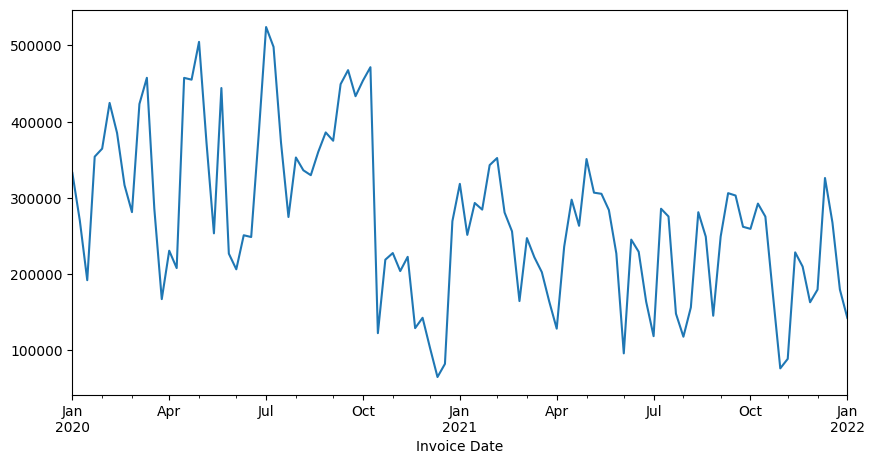

In [232]:
encoded_df['Total Sales'].plot(figsize = (10,5))

#Evaluation Metrics

Triple Exponential Smoothing

In [233]:
fitted_model  =  ExponentialSmoothing(train_data['Total Sales'], trend = 'add', seasonal_periods = 1).fit()

In [234]:
test_predictions = fitted_model.forecast(6)

In [235]:
test_predictions

2021-07-18    264950.162286
2021-07-25    274962.339489
2021-08-01    284974.516693
2021-08-08    294986.693896
2021-08-15    304998.871099
2021-08-22    315011.048303
Freq: W-SUN, dtype: float64

In [236]:
 train_data['Total Sales']


Invoice Date
2020-01-05    332625.000000
2020-01-12    270375.000000
2020-01-19    191964.285714
2020-01-26    353942.307692
2020-02-02    364464.285714
                  ...      
2021-06-13    245156.250000
2021-06-20    229200.000000
2021-06-27    163845.238095
2021-07-04    118571.428571
2021-07-11    285664.062500
Freq: W-SUN, Name: Total Sales, Length: 80, dtype: float64

In [237]:
test_predictions

2021-07-18    264950.162286
2021-07-25    274962.339489
2021-08-01    284974.516693
2021-08-08    294986.693896
2021-08-15    304998.871099
2021-08-22    315011.048303
Freq: W-SUN, dtype: float64

In [238]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [239]:
test_data['Total Sales'][:6]

Invoice Date
2021-07-18    275500.000000
2021-07-25    148050.000000
2021-08-01    117857.142857
2021-08-08    156339.285714
2021-08-15    281132.812500
2021-08-22    249086.538462
Freq: W-SUN, Name: Total Sales, dtype: float64

In [240]:
mean_absolute_error(test_data['Total Sales'][:6],test_predictions)

88836.25461021462

In [241]:
np.sqrt(mean_squared_error(test_data['Total Sales'][:6],encoded_df['TES7']['2021-10-17': '2021-11-21']))

128128.97618211641

In [242]:
encoded_df['Total Sales'].mean()

272724.4011368567

SES Evaluation

In [243]:
encoded_df['SES7']

Invoice Date
2020-01-05    332625.000000
2020-01-12    291125.000000
2020-01-19    225017.857143
2020-01-26    310967.490842
2020-02-02    346632.020757
                  ...      
2021-12-05    178400.073024
2021-12-12    276766.691008
2021-12-19    270588.897003
2021-12-26    209967.132334
2022-01-02              NaN
Freq: W-SUN, Name: SES7, Length: 105, dtype: float64

In [244]:
mean_absolute_error(test_data['Total Sales'][:6],encoded_df['SES7']['2021-10-03': '2021-11-07'])

111545.50006583637

In [245]:
mean_squared_error(test_data['Total Sales'][:6],encoded_df['SES7']['2021-10-17': '2021-11-21'])

3059084000.3760285

In [246]:
np.sqrt(mean_squared_error(test_data['Total Sales'][:6],encoded_df['SES7']['2021-10-17': '2021-11-21']))

55308.98661497993

In [247]:
encoded_df['Total Sales'].mean()

272724.4011368567

DES Evaluation


In [248]:
mean_absolute_error(test_data['Total Sales'][:6],encoded_df['DES7']['2021-10-17': '2021-11-21'])

44014.23021172604

In [249]:
mean_squared_error(test_data['Total Sales'][:6],encoded_df['DES7']['2021-10-17': '2021-11-21'])

2732709569.1588225

In [250]:
np.sqrt(mean_squared_error(test_data['Total Sales'][:6],encoded_df['DES7']['2021-10-17': '2021-11-21']))

52275.32466813403

In [251]:
encoded_df['Total Sales'].mean()

272724.4011368567

#Check for Stationarity

In [252]:
len(encoded_df)

105

<Axes: xlabel='Invoice Date'>

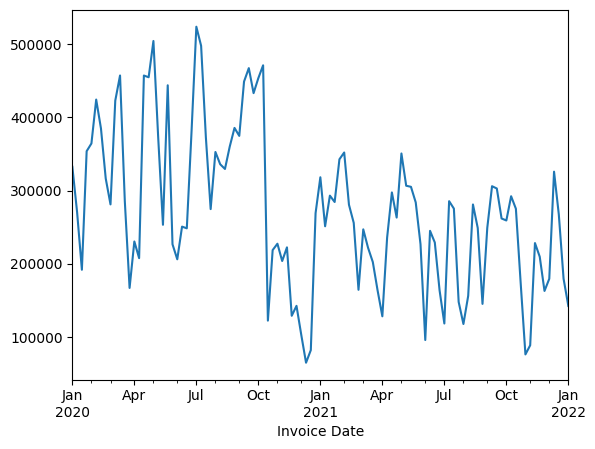

In [253]:
encoded_df['Total Sales'].plot()

In [254]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [255]:
# from statsmodels.tsa.statespace.tools import diff

In [256]:
# encoded_df['Total Sales(1)'] = diff(encoded_df['Total Sales'],k_diff=1)

In [257]:
# adf_test(encoded_df['Total Sales(1)'])

In [258]:
# encoded_df['Total Sales(1)']

#AR,ARIMA

AR(1)

In [259]:
len(encoded_df)

105

In [260]:
train_data = encoded_df.iloc[:80]
test_data = encoded_df.iloc[80:]

In [261]:
model = AutoReg(train_data['Total Sales'], lags=1)
AR1fit = model.fit()

In [262]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [263]:
start

80

In [264]:
predictions1

2021-07-18    287047.324009
2021-07-25    287923.721202
2021-08-01    288478.982833
2021-08-08    288830.781631
2021-08-15    289053.671863
2021-08-22    289194.889104
2021-08-29    289284.360540
2021-09-05    289341.047230
2021-09-12    289376.962388
2021-09-19    289399.717264
2021-09-26    289414.134139
2021-10-03    289423.268283
2021-10-10    289429.055430
2021-10-17    289432.722010
2021-10-24    289435.045057
2021-10-31    289436.516877
2021-11-07    289437.449382
2021-11-14    289438.040192
2021-11-21    289438.414513
2021-11-28    289438.651673
2021-12-05    289438.801931
2021-12-12    289438.897131
2021-12-19    289438.957447
2021-12-26    289438.995661
2022-01-02    289439.019873
Freq: W-SUN, Name: AR(1) Predictions, dtype: float64

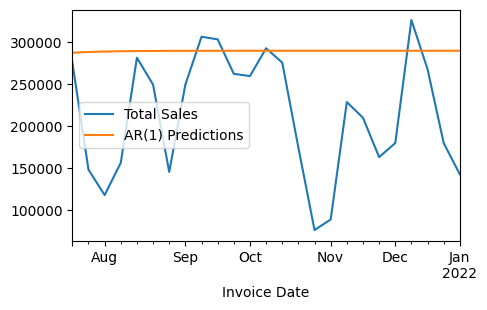

In [265]:
test_data['Total Sales'].plot(legend=True)
predictions1.plot(legend=True,figsize=(5,3));

AR(2) Model

In [266]:
model = AutoReg(train_data['Total Sales'], lags=2)
AR2fit = model.fit()

In [267]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

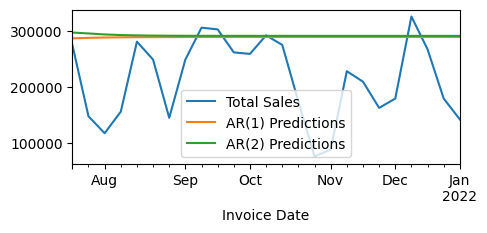

In [268]:
test_data['Total Sales'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(5,2));

AR(p) model where statsmodels chooses p

In [269]:
for i in range(1,10):
  model = AutoReg(train_data['Total Sales'], lags=i)
  ARfit = model.fit()
  predictions = ARfit.predict(start=start, end=end, dynamic=False)
  error = np.sqrt(mean_squared_error(test_data['Total Sales'], predictions))
  print(f'Lag {i} Error : {error}')
  min_error = float('inf')
  min_error = min(min_error, error)

print(min_error)



Lag 1 Error : 102989.56242069727
Lag 2 Error : 105222.04864905047
Lag 3 Error : 106669.06935771117
Lag 4 Error : 104679.34413831627
Lag 5 Error : 102067.55332965324
Lag 6 Error : 101649.54350015629
Lag 7 Error : 102804.45385110563
Lag 8 Error : 103500.86488892969
Lag 9 Error : 103025.9214621406
103025.9214621406


In [270]:
model = AutoReg(train_data['Total Sales'], lags=9)
AR9fit = model.fit()

In [271]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions9 = AR9fit.predict(start=start, end=end, dynamic=False).rename('AR(9)')

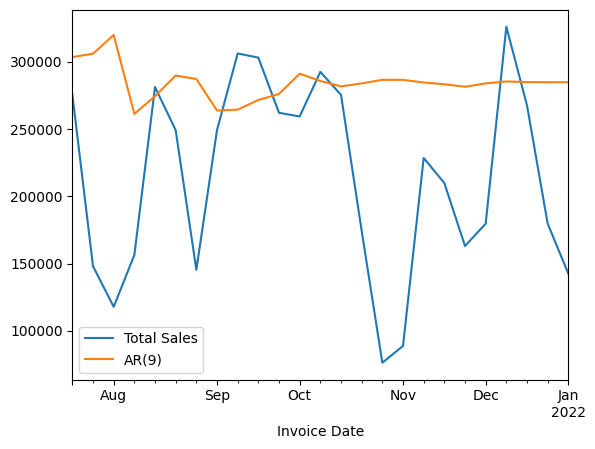

In [272]:
test_data['Total Sales'].plot(legend=True)
# predictions1.plot(legend=True)
# predictions2.plot(legend=True);
predictions9.plot(legend=True);

Evaluation

In [273]:
test_data['Total Sales']

Invoice Date
2021-07-18    275500.000000
2021-07-25    148050.000000
2021-08-01    117857.142857
2021-08-08    156339.285714
2021-08-15    281132.812500
2021-08-22    249086.538462
2021-08-29    145357.142857
2021-09-05    249196.428571
2021-09-12    306093.750000
2021-09-19    302976.190476
2021-09-26    262000.000000
2021-10-03    259285.714286
2021-10-10    292403.846154
2021-10-17    275336.538462
2021-10-24    174250.000000
2021-10-31     76339.285714
2021-11-07     88821.428571
2021-11-14    228445.312500
2021-11-21    209796.875000
2021-11-28    163035.714286
2021-12-05    179642.857143
2021-12-12    325950.000000
2021-12-19    267500.000000
2021-12-26    179656.250000
2022-01-02    142500.000000
Freq: W-SUN, Name: Total Sales, dtype: float64

In [274]:
test_data = encoded_df.iloc[-13]

In [275]:
test_data['Total Sales'].mean()

292403.8461538461

In [276]:
import math

In [ ]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(9)']
preds = [predictions1, predictions2, predictions9]

for i in range(3):
    error = np.sqrt(mean_squared_error(test_data['Total Sales'], preds[i]))
    print(f'{labels[i]} Error: {error}')

Forecast

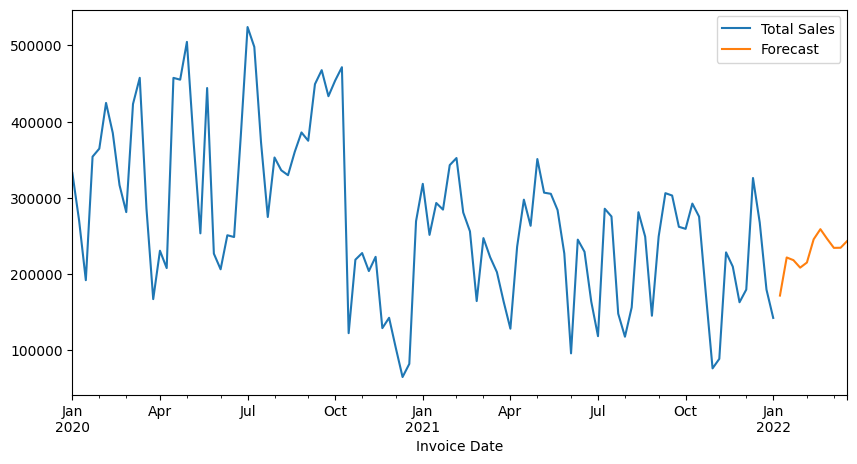

In [278]:
model = AutoReg(encoded_df['Total Sales'], lags = 9)
ARfit = model.fit()
fcast = ARfit.predict(start=len(encoded_df), end=len(encoded_df)+ 10, dynamic=False).rename('Forecast')
encoded_df['Total Sales'].plot(legend=True)
fcast.plot(legend=True,figsize=(10,5));

In [279]:
fcast

2022-01-09    171799.196968
2022-01-16    221763.117366
2022-01-23    218239.935801
2022-01-30    208406.996071
2022-02-06    215144.701289
2022-02-13    245585.630438
2022-02-20    258865.604810
2022-02-27    246191.074882
2022-03-06    234355.856987
2022-03-13    234500.088695
2022-03-20    243596.676778
Freq: W-SUN, Name: Forecast, dtype: float64

ARIMA

In [280]:
auto_arima(encoded_df['Total Sales'], seasonal = False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1325.421
Date:                Wed, 09 Aug 2023   AIC                           2656.843
Time:                        03:05:34   BIC                           2664.776
Sample:                    01-05-2020   HQIC                          2660.057
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6000      0.136      4.414      0.000       0.334       0.866
ma.L1         -0.9531      0.060    -15.827      0.000      -1.071      -0.835
sigma2      7.474e+09   1.84e-12   4.07e+21      0.000    7.47e+09    7.47e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 4.99
Prob(Q):                              0.41   Prob(JB):                         0.08
Heteroskedasticity (H):               0.56   Skew:                            -0.11
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+37. Standard errors may be unstable.
"""

In [281]:
model2 = ARIMA(encoded_df['Total Sales'], order = (1,1,1))

In [282]:
results = model2.fit()

In [283]:
len(encoded_df)

105

In [284]:
train_data = encoded_df[:90]
test_data = encoded_df[90:]

In [285]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [286]:
predictions = results.predict(start,end).rename('ARIMA Model')

<Axes: xlabel='Invoice Date'>

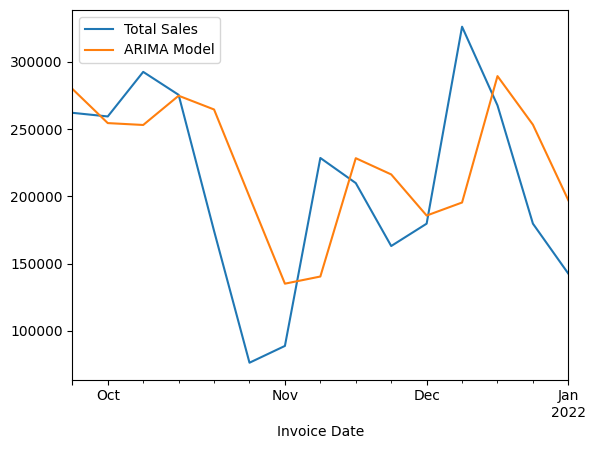

In [287]:
test_data['Total Sales'].plot(legend = True)
predictions.plot(legend = True)

In [288]:
from statsmodels.tools.eval_measures import rmse

In [289]:
error = rmse(test_data['Total Sales'],predictions)
error

65439.085960518365

In [290]:
test_data['Total Sales'].mean()

208330.92147435897

In [291]:
fcast = results.predict(len(encoded_df),len(encoded_df)+10).rename(' ARIMA Forecast')

In [292]:
fcast

2022-01-09    172168.841444
2022-01-16    189968.924578
2022-01-23    200648.241468
2022-01-30    207055.391839
2022-02-06    210899.418221
2022-02-13    213205.675758
2022-02-20    214589.335310
2022-02-27    215419.474064
2022-03-06    215917.523132
2022-03-13    216216.332063
2022-03-20    216395.605118
Freq: W-SUN, Name:  ARIMA Forecast, dtype: float64

<Axes: xlabel='Invoice Date'>

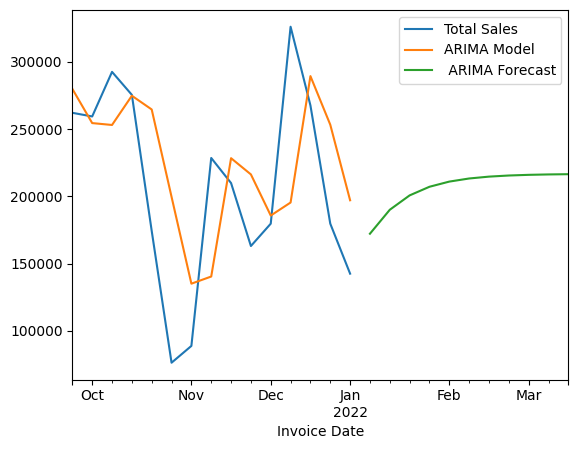

In [293]:
test_data['Total Sales'].plot(legend = True)
predictions.plot(legend = True)
fcast.plot(legend = True)

#ARIMAX

In [294]:
train_data = encoded_df[:80]
test_data = encoded_df[80:]

In [295]:
model2 = ARIMA(endog = train_data['Total Sales'],exog = train_data.iloc[:, 7:57],  order = (1,1,1),seasonal_order = (1,1,1,7),enforce_invertibility=False)

In [296]:
results = model2.fit()

In [297]:
len(encoded_df)

105

In [298]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [299]:
predictions = results.predict(start = start, end = end, exog = test_data.iloc[:, 7:57]).rename('ARIMAX Predictions')

<Axes: xlabel='Invoice Date'>

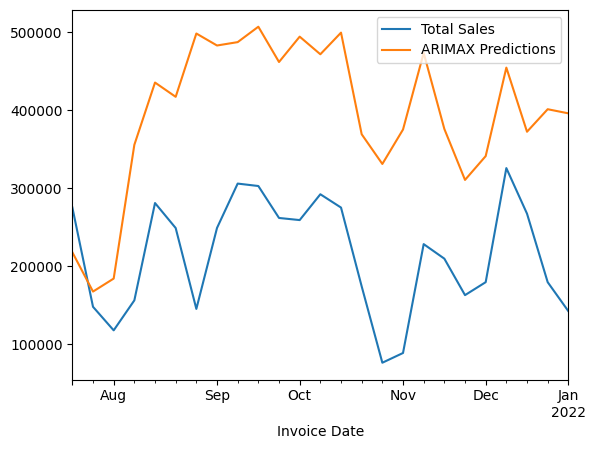

In [300]:
test_data['Total Sales'].plot(legend = True)
predictions.plot(legend = True)

In [301]:
from statsmodels.tools.eval_measures import rmse

In [302]:
error = rmse(test_data['Total Sales'],predictions)
error

199436.0841938987

In [303]:
test_data['Total Sales'].mean()

214262.12454212457

fcast

<Axes: xlabel='Invoice Date'>

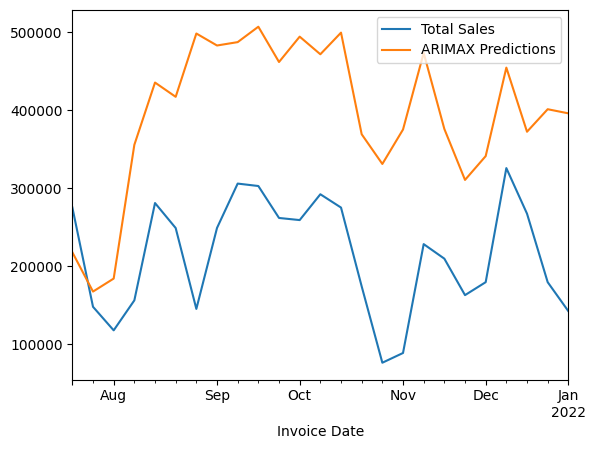

In [304]:
test_data['Total Sales'].plot(legend = True)
predictions.plot(legend = True)



#SARIMA

In [305]:
result = seasonal_decompose(encoded_df['Total Sales'], model = 'add', period = 7)

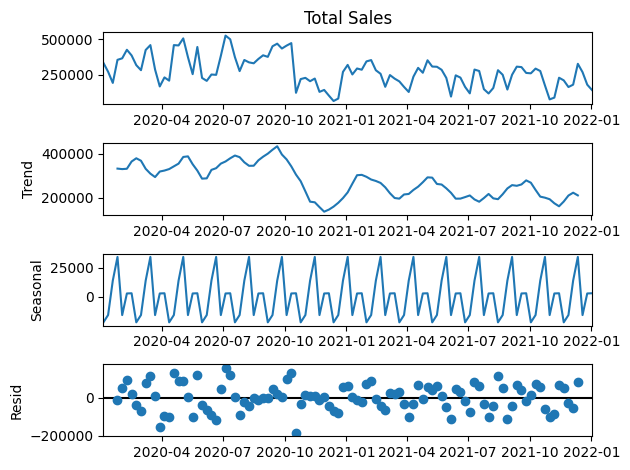

In [306]:
result.plot();

In [307]:
model = SARIMAX(train_data['Total Sales'], order = (1, 1, 1))

In [308]:
results = model.fit()

In [309]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Total Sales   No. Observations:                   80
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1010.967
Date:                Wed, 09 Aug 2023   AIC                           2027.934
Time:                        03:05:40   BIC                           2035.042
Sample:                    01-05-2020   HQIC                          2030.782
                         - 07-11-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6369      0.157      4.054      0.000       0.329       0.945
ma.L1         -0.9689      0.080    -12.113      0.000      -1.126      -0.812
sigma2      8.311e+09   1.07e-12   7.78e+21      0.000    8.31e+09    8.31e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 4.58
Prob(Q):                              0.73   Prob(JB):                         0.10
Heteroskedasticity (H):               0.38   Skew:                            -0.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+38. Standard errors may be unstable.
"""

In [310]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [311]:
predictions = results.predict(start, end).rename('SARIMA Predictions')

In [312]:
from statsmodels.tools.eval_measures import rmse

In [313]:
error = rmse(test_data['Total Sales'],predictions)

In [314]:
error

86093.48192280582

In [315]:
test_data['Total Sales'].mean()

214262.12454212457

In [316]:
test_data.shape

(25, 70)

In [317]:
test_data.iloc[:, 6:60]

,Retailer_Amazon,Retailer_Foot Locker,Retailer_Kohl's,Retailer_Sports Direct,Retailer_Walmart,Retailer_West Gear,Region_Midwest,Region_Northeast,Region_South,Region_Southeast,...,City_Minneapolis,City_New York,City_Omaha,City_Orlando,City_Philadelphia,City_Portland,City_Richmond,City_San Francisco,City_Seattle,Product_Men's Apparel
Invoice Date,,,,,,,,,,,,,,,,,,,,,
2021-07-18,0.000000,0.700000,0.000000,0.000000,0.300000,0.000000,0.700000,0.000000,0.000000,0.300000,...,0.0,0.0,0.350000,0.300000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-07-25,0.300000,0.700000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000,0.000000,0.000000,...,0.0,0.0,0.350000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-08-01,0.000000,0.928571,0.000000,0.071429,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-08-08,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.714286,0.000000,0.285714,0.000000,...,0.0,0.0,0.214286,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-08-15,0.000000,0.187500,0.187500,0.375000,0.062500,0.187500,0.187500,0.187500,0.250000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-08-22,0.230769,0.000000,0.000000,0.538462,0.230769,0.000000,0.000000,0.000000,0.538462,0.230769,...,0.0,0.0,0.000000,0.230769,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-08-29,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-09-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2021-09-12,0.000000,0.000000,0.187500,0.437500,0.187500,0.187500,0.000000,0.187500,0.437500,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


<Axes: xlabel='Invoice Date'>

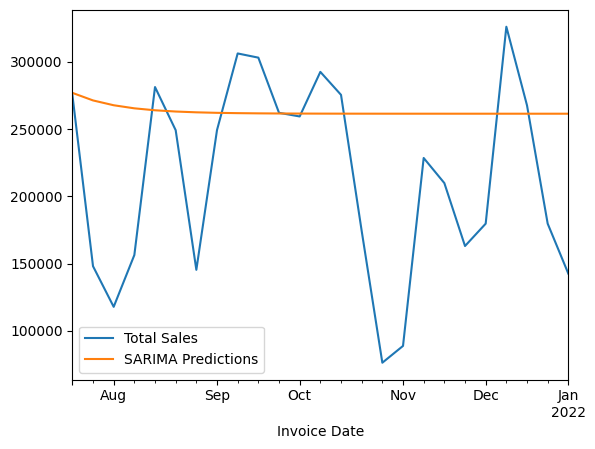

In [318]:
test_data['Total Sales'].plot(legend = True)
predictions.plot(legend = True)

In [319]:
fcast = results.predict(len(encoded_df),len(encoded_df)+10, exog = test_data.iloc[:, 6:60]).rename('Forecast')

#SARIMAX

In [320]:
encoded_df.shape

(105, 70)

In [321]:
encoded_df.columns

Index(['Retailer ID', 'Price per Unit', 'Units Sold', 'Total Sales',
       'Operating Profit', 'Operating Margin', 'Retailer_Amazon',
       'Retailer_Foot Locker', 'Retailer_Kohl's', 'Retailer_Sports Direct',
       'Retailer_Walmart', 'Retailer_West Gear', 'Region_Midwest',
       'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West',
       'State_Alabama', 'State_Alaska', 'State_California', 'State_Colorado',
       'State_Florida', 'State_Hawaii', 'State_Illinois', 'State_Maine',
       'State_Minnesota', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New York', 'State_Pennsylvania', 'State_Tennessee',
       'State_Texas', 'State_Virginia', 'State_Washington', 'State_Wyoming',
       'City_Albany', 'City_Anchorage', 'City_Billings', 'City_Birmingham',
       'City_Cheyenne', 'City_Chicago', 'City_Dallas', 'City_Denver',
       'City_Honolulu', 'City_Houston', 'City_Knoxville', 'City_Las Vegas',
       'City_Los Angeles', 'City_Miami', 'City_Minn

In [322]:
train = encoded_df[:80]
test = encoded_df[80:]

In [323]:
encoded_df.columns

Index(['Retailer ID', 'Price per Unit', 'Units Sold', 'Total Sales',
       'Operating Profit', 'Operating Margin', 'Retailer_Amazon',
       'Retailer_Foot Locker', 'Retailer_Kohl's', 'Retailer_Sports Direct',
       'Retailer_Walmart', 'Retailer_West Gear', 'Region_Midwest',
       'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West',
       'State_Alabama', 'State_Alaska', 'State_California', 'State_Colorado',
       'State_Florida', 'State_Hawaii', 'State_Illinois', 'State_Maine',
       'State_Minnesota', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New York', 'State_Pennsylvania', 'State_Tennessee',
       'State_Texas', 'State_Virginia', 'State_Washington', 'State_Wyoming',
       'City_Albany', 'City_Anchorage', 'City_Billings', 'City_Birmingham',
       'City_Cheyenne', 'City_Chicago', 'City_Dallas', 'City_Denver',
       'City_Honolulu', 'City_Houston', 'City_Knoxville', 'City_Las Vegas',
       'City_Los Angeles', 'City_Miami', 'City_Minn

In [324]:
selected_cols = ['3-week-SMA'	,'6-week-SMA',	'12-week-SMA',	'EWMA',	'SES7'	,'DES7',	'TES7', '2-week-SMA']

In [325]:
train.drop(selected_cols, axis = 1, inplace = True)

In [326]:
len(train.columns)

62

In [327]:
train.columns

Index(['Retailer ID', 'Price per Unit', 'Units Sold', 'Total Sales',
       'Operating Profit', 'Operating Margin', 'Retailer_Amazon',
       'Retailer_Foot Locker', 'Retailer_Kohl's', 'Retailer_Sports Direct',
       'Retailer_Walmart', 'Retailer_West Gear', 'Region_Midwest',
       'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West',
       'State_Alabama', 'State_Alaska', 'State_California', 'State_Colorado',
       'State_Florida', 'State_Hawaii', 'State_Illinois', 'State_Maine',
       'State_Minnesota', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New York', 'State_Pennsylvania', 'State_Tennessee',
       'State_Texas', 'State_Virginia', 'State_Washington', 'State_Wyoming',
       'City_Albany', 'City_Anchorage', 'City_Billings', 'City_Birmingham',
       'City_Cheyenne', 'City_Chicago', 'City_Dallas', 'City_Denver',
       'City_Honolulu', 'City_Houston', 'City_Knoxville', 'City_Las Vegas',
       'City_Los Angeles', 'City_Miami', 'City_Minn

In [328]:
model = SARIMAX(train['Total Sales'],exog=train.iloc[: ,7:57],order=(1,1,1),seasonal_order=(1,1,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Total Sales   No. Observations:                   80
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -898.038
Date:                           Wed, 09 Aug 2023   AIC                           1906.075
Time:                                   03:05:44   BIC                           2031.292
Sample:                               01-05-2020   HQIC                          1955.924
                                    - 07-11-2021                                         
Covariance Type:                             opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Retailer_Foot Locker    -3.02e+04   1.79e+05     -0.168      0.866   -3.81e+05    3.21e+05
Retailer_Kohl's         1.868e+05   5.18e+05      0.360      0.719   -8.29e+05     1.2e+06
Retailer_Sports Direct  2.172e+05   1.82e+05      1.196      0.232   -1.39e+05    5.73e+05
Retailer_Walmart        2.654e+05   2.04e+05      1.303      0.193   -1.34e+05    6.65e+05
Retailer_West Gear      1.163e+05   2.15e+05      0.542      0.588   -3.04e+05    5.37e+05
Region_Midwest         -3.561e+04   4.07e+05     -0.088      0.930   -8.33e+05    7.62e+05
Region_Northeast        5.219e+04   2.21e+05      0.236      0.813   -3.81e+05    4.85e+05
Region_South           -5.874e+04   2.23e+05     -0.263      0.792   -4.96e+05    3.79e+05
Region_Southeast        1.435e+04   2.98e+05      0.048      0.962   -5.69e+05    5.98e+05
Region_West             2.781e+04   2.68e+05      0.104      0.917   -4.98e+05    5.54e+05
State_Alabama          -1.165e-11   1.38e+05  -8.41e-17      1.000   -2.71e+05    2.71e+05
State_Alaska           -2.265e+04   2.57e+05     -0.088      0.930   -5.26e+05    4.81e+05
State_California        1.275e+05   2.19e+05      0.581      0.561   -3.03e+05    5.58e+05
State_Colorado         -6.864e+04   1.04e+05     -0.660      0.509   -2.72e+05    1.35e+05
State_Florida          -1.274e+04   1.81e+05     -0.070      0.944   -3.67e+05    3.42e+05
State_Hawaii           -5.742e+04   3.45e+05     -0.166      0.868   -7.34e+05    6.19e+05
State_Illinois          3.327e+04   7.32e+05      0.045      0.964    -1.4e+06    1.47e+06
State_Maine            -1.227e+04   6.26e+05     -0.020      0.984   -1.24e+06    1.22e+06
State_Minnesota         5.861e+04   1.71e+05      0.344      0.731   -2.76e+05    3.93e+05
State_Montana          -1773.2435    3.2e+05     -0.006      0.996   -6.29e+05    6.26e+05
State_Nebraska         -1.257e+05   5.32e+05     -0.236      0.813   -1.17e+06    9.17e+05
State_Nevada           -5776.6257   1.49e+05     -0.039      0.969   -2.98e+05    2.86e+05
State_New York          9.434e+04    3.9e+05      0.242      0.809   -6.71e+05     8.6e+05
State_Pennsylvania     -2.988e+04   3.26e+05     -0.092      0.927   -6.69e+05    6.09e+05
State_Tennessee        -8.301e+04   2.59e+05     -0.320      0.749   -5.91e+05    4.25e+05
State_Texas             2.427e+04   1.36e+05      0.178      0.858   -2.42e+05    2.91e+05
State_Virginia          2.709e+04   3.23e+05      0.084      0.933   -6.06e+05    6.61e+05
State_Washington        1.642e+04      2e+05      0.082      0.935   -3.76e+05    4.08e+05
State_Wyoming           3.834e+04   3.72e+05      0.103      0.918    -6.9e+05    7.67e+05
City_Albany            -1.892e+05    5.6e+05     -0.338      0.735   -1.29e+06    9.08e+05
City_Anchorage         -2.265e+04   2.57e+05     -0.088      0.930   -5.26e+05    4.81e+05
City_Billings          -1773.2435    3.2e+05    

In [329]:
start = len(train)
end = len(train) + len(test) - 1

In [330]:
predictions = results.predict(start = start, end = end, exog = test.iloc[:, 7:57]).rename('SARIMAX Predictions')

In [331]:
test_data.columns

Index(['Retailer ID', 'Price per Unit', 'Units Sold', 'Total Sales',
       'Operating Profit', 'Operating Margin', 'Retailer_Amazon',
       'Retailer_Foot Locker', 'Retailer_Kohl's', 'Retailer_Sports Direct',
       'Retailer_Walmart', 'Retailer_West Gear', 'Region_Midwest',
       'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_West',
       'State_Alabama', 'State_Alaska', 'State_California', 'State_Colorado',
       'State_Florida', 'State_Hawaii', 'State_Illinois', 'State_Maine',
       'State_Minnesota', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New York', 'State_Pennsylvania', 'State_Tennessee',
       'State_Texas', 'State_Virginia', 'State_Washington', 'State_Wyoming',
       'City_Albany', 'City_Anchorage', 'City_Billings', 'City_Birmingham',
       'City_Cheyenne', 'City_Chicago', 'City_Dallas', 'City_Denver',
       'City_Honolulu', 'City_Houston', 'City_Knoxville', 'City_Las Vegas',
       'City_Los Angeles', 'City_Miami', 'City_Minn

In [332]:
from statsmodels.tools.eval_measures import rmse

In [333]:
predictions

2021-07-18    217997.843018
2021-07-25    167591.703001
2021-08-01    184268.201890
2021-08-08    355815.251496
2021-08-15    435680.539994
2021-08-22    417356.759981
2021-08-29    498569.777942
2021-09-05    483192.380344
2021-09-12    487528.823257
2021-09-19    507275.287629
2021-09-26    462030.746079
2021-10-03    494544.220693
2021-10-10    471944.385033
2021-10-17    499694.987520
2021-10-24    369361.753144
2021-10-31    331255.458535
2021-11-07    375431.468970
2021-11-14    473665.647311
2021-11-21    376159.549919
2021-11-28    310794.674242
2021-12-05    341325.376984
2021-12-12    454815.608207
2021-12-19    372581.140608
2021-12-26    401466.806460
2022-01-02    396175.022939
Freq: W-SUN, Name: SARIMAX Predictions, dtype: float64

In [334]:
test_data

,Retailer ID,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Retailer_Amazon,Retailer_Foot Locker,Retailer_Kohl's,Retailer_Sports Direct,...,Sales Method_In-store,Sales Method_Outlet,2-week-SMA,3-week-SMA,6-week-SMA,12-week-SMA,EWMA,SES7,DES7,TES7
Invoice Date,,,,,,,,,,,,,,,,,,,,,
2021-07-18,1.168502e+06,57.000000,373.750000,275500.000000,90590.625000,0.362500,0.000000,0.700000,0.000000,0.000000,...,0.300000,0.700000,280582.031250,226578.497024,219656.163194,240636.277568,262736.660257,262736.660257,271220.708318,117667.084222
2021-07-25,1.185732e+06,49.500000,273.500000,148050.000000,51667.500000,0.365000,0.300000,0.700000,0.000000,0.000000,...,0.000000,1.000000,211775.000000,236404.687500,203471.788194,223740.146616,186278.886752,186278.886752,177602.678164,202204.004975
2021-08-01,1.186596e+06,48.571429,258.571429,117857.142857,47044.642857,0.389286,0.000000,0.928571,0.000000,0.071429,...,0.000000,1.000000,132953.571429,180469.047619,184914.645337,208000.116854,140664.390822,140664.390822,131211.551882,167037.574963
2021-08-08,1.191782e+06,43.928571,391.071429,156339.285714,64897.321429,0.410714,0.000000,0.500000,0.000000,0.500000,...,0.000000,1.000000,137098.214286,140748.809524,183663.653274,195591.691945,151114.320750,151114.320750,149655.013689,158970.624185
2021-08-15,1.179500e+06,49.687500,558.593750,281132.812500,95490.234375,0.353125,0.000000,0.187500,0.187500,0.375000,...,0.375000,0.625000,218736.049107,185109.747024,210757.217262,195355.964782,237793.315250,237793.315250,250897.179368,216647.923148
2021-08-22,1.178993e+06,50.000000,485.576923,249086.538462,81995.192308,0.363462,0.230769,0.000000,0.000000,0.538462,...,0.230769,0.769231,265109.675481,228852.878892,204660.963255,197201.717987,245322.130724,245322.130724,250907.124423,249929.806546
2021-08-29,1.197831e+06,28.928571,530.357143,145357.142857,60709.821429,0.425000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,197221.840659,225192.164606,182970.487065,201313.325130,178678.805480,178678.805480,170504.645077,218096.336618
2021-09-05,1.197831e+06,38.214286,641.071429,249196.428571,116200.892857,0.439286,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,197276.785714,214546.703297,199828.225160,201650.006677,225690.554207,225690.554207,231220.440443,301905.228043
2021-09-12,1.180257e+06,50.625000,616.406250,306093.750000,120023.437500,0.378125,0.000000,0.000000,0.187500,0.437500,...,0.375000,0.625000,277645.089286,233549.107143,231200.993017,208057.819177,279292.684736,279292.684736,290203.560146,323229.728478


In [335]:
error = rmse(test_data['Total Sales'],predictions)

In [336]:
error

199436.0841938987

In [337]:
test_data['Total Sales'].mean()

214262.12454212457

<Axes: xlabel='Invoice Date'>

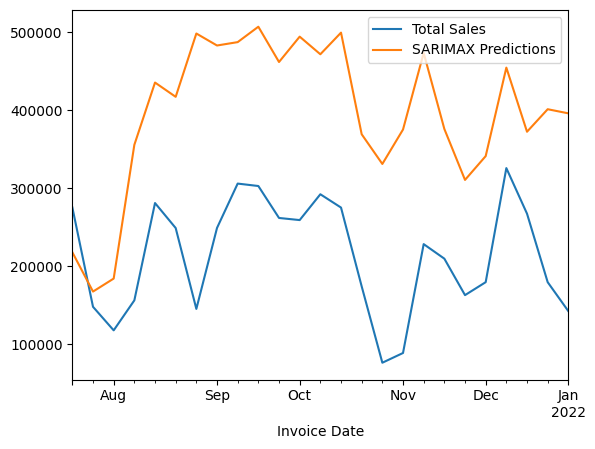

In [338]:
test_data['Total Sales'].plot(legend = True)
predictions.plot(legend = True)


#Facebook Prophet Forecasting

In [ ]:
original = pd.read_excel('/content/Men Apparel.xlsx')

In [ ]:
original

In [ ]:
columns_to_encode = ['Region', 'State', 'City', 'Product', 'Sales Method']
original_df = pd.get_dummies(original, columns=columns_to_encode)
print(list(original_df))

In [ ]:
original_df.index = pd.to_datetime(original_df.index)
original_df.set_index('Invoice Date', inplace = True)

In [ ]:
original_df = original_df.resample(rule = 'W').mean()

In [ ]:
original_df

In [ ]:
df = original_df['Total Sales'].copy()

In [ ]:
original_df.reset_index(drop=False, inplace=True)


In [ ]:
original_df

In [ ]:
selected_columns = ['Invoice Date', 'Total Sales']

In [ ]:
df = original_df[selected_columns].copy()

In [ ]:
df

In [ ]:
df.columns = ['ds', 'y']

In [ ]:
train = df.iloc[:80]
test = df.iloc[80:]

In [ ]:
from prophet import  Prophet

In [ ]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=10,freq='W')
forecast = m.predict(future)

In [ ]:
future

In [ ]:
forecast.head()

In [ ]:
forecast.tail()

In [ ]:
forecast.columns

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [ ]:
import matplotlib.pyplot as plt
m.plot(forecast);

In [ ]:
forecast.plot(x='ds',y='yhat')

In [ ]:
m.plot_components(forecast);



In [ ]:
df.plot(x= 'ds', y = 'y')

In [ ]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='True Units Sold',legend=True,ax=ax)

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
predictions = forecast.iloc[80:90]['yhat']

In [ ]:
forecast


In [ ]:
predictions

In [ ]:
test['y']

In [ ]:
test['y'].iloc[-1]


In [ ]:
rmse(predictions,test['y'].iloc[-1])

In [ ]:
test['y'].mean()

#Multivariate Forecasting

In [ ]:
original_df

In [ ]:
original_df.columns

In [ ]:
new_column_names = {
    'Invoice Date': 'ds',
    'Total Sales': 'y'
}
original_df.rename(columns=new_column_names, inplace=True)

original_df['y_original'] = original_df['y'].copy()

In [ ]:
train = original_df[:20]
test = original_df[20:]

In [ ]:
train

In [ ]:
original_df.info()

In [ ]:
original_df.columns

In [ ]:
m1= Prophet()
m1.add_regressor('Sales Method_In-store')
m1.add_regressor('Sales Method_Outlet')
m1.add_regressor('Region_Midwest')
m1.add_regressor('Region_Northeast')
m1.add_regressor('Region_South')
m1.add_regressor('Region_Southeast')
m1.add_regressor('Region_West')
m1.fit(train)



In [ ]:
future = m1.make_future_dataframe(periods=7,freq='W')


In [ ]:
m1.component_modes

In [ ]:
future['Sales Method_In-store'] = 0
future['Sales Method_Outlet'] = 1
future['Region_Northeast'] = 1
future['Region_Midwest'] = 0
future['Region_South'] = 0
future['Region_Southeast'] = 0
future['Region_West'] = 0

In [ ]:
future

In [ ]:
forecast

In [ ]:
forecast2 = m1.predict(future)

In [ ]:
test

In [ ]:
m1.plot(forecast2);